In [4]:
from bloqade import var, save, load
from bloqade.atom_arrangement import Chain
import matplotlib.pyplot as plt
import numpy as np
import os

if not os.path.isdir("data"):
    os.mkdir("data")
    
# linear atoms
def z2_to_z1(n_atoms, lattice_spacing):
    #n_atoms = 5
    #lattice_spacing = 6.1
    run_time = var("run_time")

    quantum_scar_program = (
        Chain(n_atoms, lattice_spacing=lattice_spacing)
        # define detuning waveform
        .rydberg.detuning.uniform.piecewise_linear(
            [0.3, 1.6, 0.3], [-18.8, -18.8, 16.3, 16.3]
        )
        .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])
        # slice the detuning waveform
        .slice(start=0, stop=run_time)

        # define rabi waveform
        .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0, 15.7, 15.7, 0.0])
        .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])
        # slice waveform, add padding for the linear segment
        .slice(start=0, stop=(run_time - 0.065))

        # record the value of the waveform at the end of the slice to "rabi_value"
        .record("rabi_value")
        # append segment to waveform that fixes the value of the waveform to 0
        # at the end of the waveform
        .linear("rabi_value", 0, 0.065)
    )

    # get run times via the following:
    prep_times = np.arange(0.2, 2.2, 0.5)
    scar_times = np.arange(2.2, 3.9, 0.01)
    run_times = np.unique(np.hstack((prep_times, scar_times)))

    batch = quantum_scar_program.batch_assign(run_time=run_times)

    emu_batch = batch.bloqade.python().run(100)
    
    return emu_batch

In [5]:
def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("01010", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

def get_z1_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("10101", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

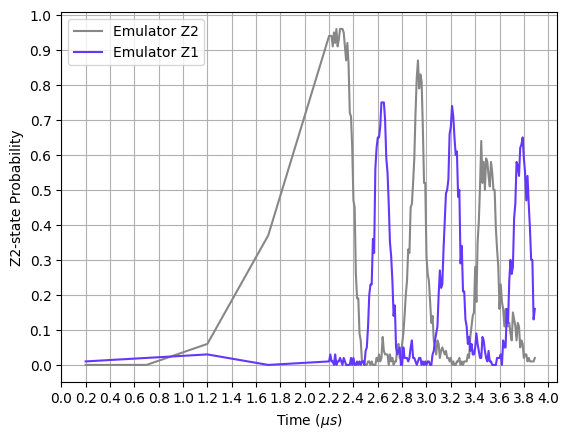

In [6]:
n_atoms = 5
lattice_spacing = 6.1
emu_batch = z2_to_z1(n_atoms, lattice_spacing)

emu_report = emu_batch.report()
#hardware_report = hardware_batch.report()

emu_run_times = emu_report.list_param("run_time")
emu_z2_prob = get_z2_probabilities(emu_report)
emu_z1_prob = get_z1_probabilities(emu_report)

#hw_run_times = hardware_report.list_param("run_time")
#hw_z2_prob = get_z2_probabilities(hardware_report)

plt.plot(emu_run_times, emu_z2_prob, label="Emulator Z2", color="#878787")
plt.plot(emu_run_times, emu_z1_prob, label="Emulator Z1", color="#6437FF")
#plt.plot(hw_run_times, hw_z2_prob, label="QPU", color="#6437FF")

plt.legend()
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Z2-state Probability")
plt.xticks(np.arange(0, 4.2, step=0.2))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid()
plt.show()